In [1]:
from __future__ import division
import sys
sys.path.insert(0, '/home/gw2397/cluster_new')
sys.path.insert(0, '/home/gw2397/pyhsmm-autoregressive-master')
sys.path.insert(0, '/home/gw2397/nbRegg_mcmc')

import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import *
from scipy.interpolate import *
from cluster_functions import *


import pyhsmm
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.stats import whiten, cov

import autoregressive.models as m
import autoregressive.distributions as d

from polyagamma import random_polyagamma
from pyhmc import hmc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import gamma, digamma
from scipy.stats import norm, nbinom, multivariate_normal, poisson
from tqdm import tqdm
import heapq

import numpy.matlib
import time
from IPython import display

import warnings
warnings.filterwarnings("ignore")
import copy

import pickle

from pymc3_hpd import *
from scipy import stats
from scipy.linalg import lstsq

/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
from __future__ import division
import sys
sys.path.insert(0, '/home/gw2397/cluster_new')
sys.path.insert(0, '/home/gw2397/pyhsmm-autoregressive-master')
sys.path.insert(0, '/home/gw2397/nbRegg_mcmc')

# Load results

In [3]:
path = "/scratch/gw2397/sim_Poi/"
filename = "Poi_sim"

In [4]:
with open(path + filename + '_t_fit.pkl', 'rb') as f: t_fit_Poi = pickle.load(f)
with open(path + filename + '_states_fit.pkl', 'rb') as f: states_fit_Poi = pickle.load(f)
with open(path + filename + '_Z_fit.pkl', 'rb') as f: Z_fit_Poi = pickle.load(f)

In [5]:
n_iter = t_fit_Poi.shape[0]
iter_use_start = int(n_iter/4)

# 1. Similarity Matrices

In [6]:
n = 10
nClus = 3
p = 2
T = 500

np.random.seed(0)
lab_neuron = np.repeat(np.arange(nClus), n)

dd = np.random.normal(size = (n*nClus,1))*0.5
C_true= np.random.normal(size = (nClus*n,p))*0.5

# works well
As = [block_diag(0.01*np.eye(p+1), 
                 0.01*np.eye(p+1), 
                 0.01*np.eye(p+1)),
      block_diag(1.01*random_rotation(p+1, theta= np.pi/20),
                 1.01*random_rotation(p+1, theta= np.pi/20),
                 1.01*random_rotation(p+1, theta= np.pi/20))]


truemodel = m.ARHSMM(
        alpha=5.,init_state_concentration=5.,
        obs_distns=[d.AutoRegression(A=A,sigma=np.eye(nClus*(p+1))*1e-2) for A in As],
        dur_distns=[pyhsmm.basic.distributions.PoissonDuration(alpha_0=100,beta_0=2)
            for state in range(len(As))],
        )


X_all_tmp, lab_t_tmp = truemodel.generate(2*T, keep=True)
X_all = X_all_tmp[501:,:].T
lab_t = lab_t_tmp[500:]


muX_all = []
for cc in range(nClus):
    muX_all.append(X_all[(cc*(p+1)):((cc+1)*(p+1)),:])
    
dynm = {}
dynm['As'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['bs'] = np.zeros((2,3*(p+1)))
dynm['Qs'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['states'] = np.zeros((T,), dtype = int)


# muX_b, C_b, delt_b.ravel(), dynamics_b

muX_all, C_true, _, _ = constraint(muX_all, C_true,dd.reshape((-1, 1)),dynm, lab_neuron)    
X_all = np.zeros_like(X_all)
for cc in range(nClus):
    X_all[(cc*(p+1)):((cc+1)*(p+1)),:] = muX_all[cc]

    
C_trans = np.zeros((n*nClus, (p+1)*nClus))
for cc in range(nClus):
    C_trans[(n*cc):(n*(cc+1)),(cc*(p+1)):((cc+1)*(p+1))] = np.column_stack((np.ones((n,1)), C_true[(n*cc):(n*(cc+1)),:]))    
    
Lam_true = np.exp(dd + C_trans @ X_all)
r_true = np.ones((n*nClus,1))*10
p_true = r_true/(r_true+Lam_true)
y = np.random.negative_binomial(r_true, p_true, size=None)

## 1A. neuron

In [7]:
N = Z_fit_Poi.shape[1]
simMat_neuron = np.zeros((N,N))
count = 0
for g in range(iter_use_start, n_iter):
    count = count + 1
    for k in range(simMat_neuron.shape[0]):
        simMat_neuron[k,:] = simMat_neuron[k,:] + (Z_fit_Poi[g,k] == Z_fit_Poi[g,:])
simMat_neuron = simMat_neuron/count

simMat_neuron_true = np.zeros((N,N))
for k in range(simMat_neuron_true.shape[0]):
    simMat_neuron_true[k,:] = (lab_neuron[k] == lab_neuron)

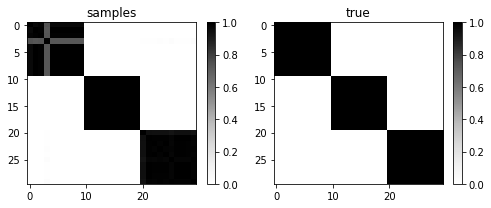

In [8]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)
z1 = ax[0].imshow(simMat_neuron, aspect="auto", cmap = 'Greys')
ax[0].set_title('samples')
plt.colorbar(z1, ax= ax[0])
z2 = ax[1].imshow(simMat_neuron_true, aspect="auto", cmap = 'Greys')
ax[1].set_title('true')
plt.colorbar(z2, ax= ax[1])
fig.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig("simMat_neuron_poi.svg")

## 1B. states

In [9]:
simMat_state = np.zeros((T,T))
count = 0

for g in range(iter_use_start, n_iter):
    count = count + 1
    for k in range(simMat_state.shape[0]):
        simMat_state[k,:] = simMat_state[k,:] + (states_fit_Poi[g,k] == states_fit_Poi[g,:])
simMat_state = simMat_state/count

simMat_state_true = np.zeros((T,T))
for k in range(simMat_state_true.shape[0]):
    simMat_state_true[k,:] = (lab_t[k] == lab_t)
sim_order = np.append(np.where(lab_t == 0)[0], np.where(lab_t == 1)[0])

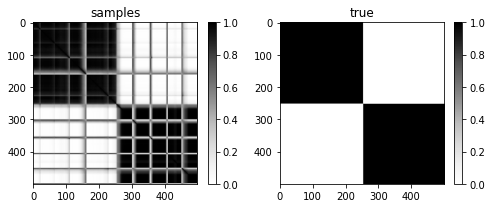

In [10]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)
z1 = ax[0].imshow(simMat_state[np.ix_(sim_order, sim_order)], aspect="auto", cmap = 'Greys')
ax[0].set_title('samples')
plt.colorbar(z1, ax= ax[0])
z2 = ax[1].imshow(simMat_state_true[np.ix_(sim_order, sim_order)], aspect="auto", cmap = 'Greys')
ax[1].set_title('true')
plt.colorbar(z2, ax= ax[1])
fig.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig("simMat_states_poi.svg")

# 2. maxPEAR of states

In [11]:
states_samp_use = states_fit_Poi[iter_use_start:,:]
np.savetxt("states_samp.csv", states_samp_use, delimiter=",")

In [12]:
states_samp_maxPEAR = np.loadtxt("states_samp_maxPEAR.csv", delimiter=",", dtype = int) - 1

In [13]:
np.unique(states_samp_maxPEAR) # 2
swap = {0: 1, 1:0}
states_samp_maxPEAR_swap = np.array([swap[x] for x in states_samp_maxPEAR])

sum((states_samp_maxPEAR - lab_t)**2)
sum((states_samp_maxPEAR_swap - lab_t)**2)

473

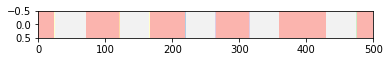

In [14]:
plt.rcParams['figure.figsize'] = [6, .5]
plt.imshow(states_samp_maxPEAR[None,:], aspect="auto", cmap='Pastel1')
plt.xlim([0, T])
plt.savefig("states_maxPEAR_poi.svg")